## Graph

In [8]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import  StateGraph, START, END
from langgraph.graph.message import add_messages ## work add the msg appeneded to the state

In [9]:
## state
class State(TypedDict):
    # Msg have type list defines how this state key should be updated

    messages : Annotated[list, add_messages] ## appended to the list

graph_bilder =StateGraph(State)

graph_bilder

In [10]:
## Building the graph

import os
from dotenv import load_dotenv
load_dotenv()


True

In [ ]:
from langchain_groq import  ChatGroq
from langchain.chat_models import init_chat_model

llm =ChatGroq(model="openai/gpt-oss-20b")

In [12]:
llm 

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001CED70F7E00>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001CED7250C20>, model_name='openai/gpt-oss-20b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [13]:
## node Chatbot

def chatbot(state:State):
    return {"messages": [llm.invoke(state['messages'])]}

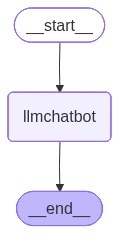

In [14]:
graph_builder = StateGraph(State)

#adding node

graph_builder.add_node("llmchatbot", chatbot)

#adding edge -- adding the node names
graph_builder.add_edge(START, "llmchatbot") 
graph_builder.add_edge("llmchatbot", END)


## compile graph 

graph = graph_builder.compile()


## visualize

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass



In [15]:
## Run the LLM 
response = graph.invoke({"messages":"Hi how are you?"})
response["messages"][-1].content

"Hello! I'm doing great—thanks for asking. How are you doing today?"

In [16]:
for event in graph.stream({"messages": "Hi How are you? and who are you?"}):
    for value in event.values():
        print(value["messages"][-1].content)

Hi there! I’m doing great—thanks for asking. I’m ChatGPT, a large language model created by OpenAI. I’m here to help answer questions, chat about a wide range of topics, and assist with whatever you need. How can I help you today?


## chatbot with Tool

In [33]:
from langchain_tavily import TavilySearch

tool =TavilySearch(max_results=2)
tool.invoke("What is Langgraph?")

{'query': 'What is Langgraph?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.analyticsvidhya.com/blog/2024/07/langgraph-revolutionizing-ai-agent/',
   'title': 'What is LangGraph?',
   'content': '* LangGraph is a library built on top of Langchain that is designed to facilitate the creation of cyclic graphs for large language model (LLM) – based AI agents. * Langgraph introduces a chat agent executor that represents the agent state as a list of messages, which is particularly useful for newer, chat-based models. The agent executor class in the Langchain framework was the main tool for building and executing AI agents before LangGraph. Large Language Models (LLMs) are the foundation for designing sophisticated AI agents, and LangGraph, built on top of Langchain, is intended to make the process of creating cyclic graphs easier. Ans. LangGraph addresses the limitations of previous AI agent development frameworks by providing more flexibil

In [57]:
def multiply(a : int, b:int)-> int:
    """ 
    Multiply a and b
    Args:
        a first int
        b seoncd int
    return: 
        int output
    """
    return a*b

In [58]:
tools =[tool, multiply]
llm_with_tools = llm.bind_tools(tools)

llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001CED77A8550>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001CED77A8F50>, model_name='openai/gpt-oss-20b', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A l

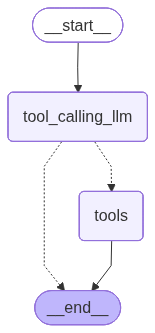

In [59]:
## Stategraph for llm with tool

from langgraph.prebuilt import ToolNode, tools_condition


def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}


# Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm) ## need to add the name and the definition of the node
builder.add_node("tools", ToolNode(tools))


# edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition

)

builder.add_edge("tools", END)

graph = builder.compile()

# visualize

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass



In [66]:
response= graph.invoke({"messages": "What is the latest new video model from OpenAI?"})

response["messages"][-1].content

for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the latest new video model from OpenAI?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (fc_c2b513c1-3bce-494e-bb1c-14db9a2777e3)
 Call ID: fc_c2b513c1-3bce-494e-bb1c-14db9a2777e3
  Args:
    query: latest new video model from OpenAI 2024
    search_depth: advanced
    start_date: 2024-01-01
================================= Tool Message =================================
Name: tavily_search

{"query": "latest new video model from OpenAI 2024", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://openai.com/index/sora-2/", "title": "Sora 2 is here", "content": "18 hours ago—Today we're releasingSora 2, our flagship video and audio generation model. The original Sora model⁠ from February 2024 was in many ways", "score": 0.7180613, "raw_content": null}, {"url": "https://openai.com/index/sora/", "title": "S

In [ ]:
## Multiplication part
response= graph.invoke({"messages": "give me the latest sora news then What 2*3.3 then add 10"})
response["messages"][-1].content
for m in response["messages"]:
    m.pretty_print()

## here you can see tool call happened but only 1st one happened, not the multiply. 

================================ Human Message =================================

give me the latest sora news then What 2*3.3 then add 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (fc_e671d38e-caa6-4205-bcc6-77cd15064069)
 Call ID: fc_e671d38e-caa6-4205-bcc6-77cd15064069
  Args:
    query: Sora latest news
    search_depth: advanced
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "Sora latest news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.cnet.com/tech/services-and-software/openais-video-generator-gets-new-social-media-app-with-sora-2/", "title": "OpenAI's Video Generator Gets New Social Media App With Sora 2 - CNET", "score": 0.756098747253418, "published_date": "Tue, 30 Sep 2025 17:16:00 GMT", "content": "# OpenAI's Video Generator Gets New Social Media App With Sora 

In [9]:
def add(*args:int)->int:
    total = 0
    for num in args:
        total += num
    return total

add(2,8,4,5,6,7,8,4,3,65,7,8,45,5,3,2,1)

183